## **Import Necessary Modules**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pip install biopython

     |████████████████████████████████| 2.3 MB 5.3 MB/s 


In [ ]:
import os
import keras
import numpy as np
from sklearn.preprocessing import MultiLabelBinarizer
from Bio import SeqIO  
import pandas as pd
from keras.utils import np_utils
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.cluster import KMeans
from keras.models import Sequential
from keras.layers import Flatten, Dense, Dropout, Embedding, LSTM
from keras import regularizers, layers, preprocessing
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score, f1_score
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, average_precision_score, classification_report
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import pandas as pd
import tensorflow as tf
from sklearn.utils import shuffle

## **Dictionary definition**

In [ ]:
dd = {
    'Aminoglycosides': ['phosphorylation', 'acetylation', 'nucleotidylation', 'efflux', 'altered target'],
    'betalactams': ['hydrolysis', 'efflux', 'altered target'],
    'Glycopeptides': ['reprogramming peptidoglycan biosynthesis'],
    'Rifampin': ['ADP-ribosylation', 'efflux', 'altered target'],
    'MLS': ['hydrolysis', 'phosphorylation', 'nucleotidylation','acetylation','efflux', 'altered target'],
    'Tetracyclines': ['monooxygenation', 'efflux', 'altered target'],
    'Sulfonamides': ['efflux','altered target'],
    'Lipopeptides' : ['altered target'],
    'Phenicol' : ['acetylation', 'efflux', 'altered target'],
}

## **Generation of Resistance CSVs**

The original CSVs are the base for the generation of the Resistance input data. Due to the prior processes of filtering the sequences based on size (in early development of the process), some antibiotics have 2 different CSVs. Since now we are mixing everything and only keeping track of the antibiotic it resists, they will be under the same name.

**Paths must be changed to run in your Drive environment**

In [ ]:
new_csv=open('YOUR-DESIRED-PATH/Resistance_mech.csv', 'w') # This one will be transformed to the resistance mechanisms using the dictionary
res = open('YOUR-DESIRED-PATH/Resistance.csv', 'w') #This one keeps all the original antibiotic names
# Writing the Header----------------------------
res.write('resistant,genes'+'\n')
new_csv.write('resistant,genes' + '\n')
#Reading the original data CSV's-----------------------------------------------
names=os.listdir('PATH-TO-CSVS')
for i in names:
  csv=pd.read_csv('PATH-TO-CSVS/'+i)
  for index, row in csv.iterrows():
    if row['resistant']==True: # The original data had True and False cases for the different antibiotics, now we only wish to keep the Trues
      row['resistant']=i.split('.')[0] # Keeping only the name without the extension
      if '2' in row['resistant']: # Important! Getting rid of the extension that marks secondary CSVs for the antibiotic type and keeping the name only 
        row['resistant']=row['resistant'][0:-1]
      if row['resistant'] in dd:
        new_csv.write(str(':'.join(dd[row['resistant']]))+','+(str(row['genes'])) +'\n') #Using the dicitonary we can transform all the names to their mechanisms, separated by ':'
        res.write(str(row['resistant'])+','+str(row['genes'])+'\n') # For the CSV we will use in the integrated coupled pipeline, we only want to keep the antibiotic type.
        
#Closing the opened files
new_csv.close()
res.close()


  

## **CNN architecture and data preprocessing**
Credit to: https://www.kaggle.com/drscarlat/predict-antibiotic-resistance-w-gene-sequence/

In [ ]:
def cnn():
  model = Sequential()
  model.add(Embedding(64, 9, input_length=maxlen))
  model.add(layers.Conv1D(128, 243, activation='relu'))
  model.add(layers.MaxPooling1D(3))
  model.add(layers.Dropout(0.5))
  model.add(layers.Conv1D(128, 81, activation='relu'))
  model.add(layers.Dropout(0.5))
  model.add(layers.Conv1D(128, 27, activation='relu'))
  model.add(layers.MaxPooling1D(3))
  model.add(layers.Dropout(0.5))
  model.add(layers.Conv1D(128, 9, activation='relu'))
  model.add(layers.MaxPooling1D(3))
  model.add(layers.Dropout(0.5))
  model.add(layers.Bidirectional(layers.GRU(32, dropout=0.2, recurrent_dropout=0.5)))
  model.add(Dense(9, activation='sigmoid'))
  model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
  model.summary()
  return(model)

In [ ]:
Dataframe = pd.read_csv('DESIRED-PATH/Resistance_mech.csv') #Reading the generated CSV
Dataframe = shuffle(Dataframe) #The shuffle is necessary to ensure that all antibiotic types are included in the test set afterwards
mlb = MultiLabelBinarizer() # Starting the Binarizer for the multiple labels

#We convert the cell with the resistance mechanisms to a list, facilitating the later binarizing process
for index, row in Dataframe.iterrows():
  row['resistant']=np.asarray(row['resistant'].split(':'))

#Process of conversion from aminoacid sequence to codon sequence
Datacodons = Dataframe.copy()

Codons = list(Datacodons['genes'])

length = []
for n in range(len(Codons)):
    Codons[n] = list([Codons[n][i:i+3] for i in range(0, len(Codons[n]), 3)])
    length.append(len(Codons[n]))
    
Datacodons['codons'] = Codons

#The maximum length will be used for the padding of sequences
maxlen = max(length) 

max_words = 64 # Number of words in the dictionary, equal to the number of  possible codons
max_features = max_words

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(list(Datacodons['codons']))
sequences = tokenizer.texts_to_sequences(list(Datacodons['codons']))
word_index = tokenizer.word_index
Pad_input = pad_sequences(sequences, maxlen=maxlen, padding='post', truncating='post', value=0)

# This step ensures that the generated dictionary has exactly what we asked for since in some cases words that are not codons are generated
new_dict= {'cac', 'cgt', 'aat', 'atg', 'tac', 'att', 'tgg', 'gac', 'tgc', 'act', 'gtt', 'gaa', 'aaa', 'cag', 'tga', 'ttg', 'gct', 'ttc', 'tct', 'ggc', 'aca', 'taa', 'ctg', 'ata', 'caa', 'ctt', 'tcg', 'gtc', 'aac', 'gga', 'acg', 'gca', 'tta', 'cta', 'acc', 'gat', 'tca', 'tat', 'agg', 'tgt', 'gtg', 'cga', 'cgc', 'ttt', 'aga', 'ggt', 'ctc', 'cca', 'ccg', 'gcg', 'a', 'ga', 'tag', 'atc', 'cat', 'agt', 'cgg', 'aag', 'gag', 'cct', 'gta', 'ggg', 'tcc', 'agc', 'ccc', 'gcc'}
unwanted= set(word_index) - set(new_dict)
for unwanted_key in unwanted: del word_index[unwanted_key]


# We use the multi label binarizer started earlier to convert the labels in the desired format, arrays of zeros and ones
encode=mlb.fit_transform(Datacodons['resistant'])
labels = np.asarray(mlb.fit_transform(Datacodons['resistant']))


training_samples = int(Pad_input.shape[0] * 0.8) # This number will be used to separate between train set (80% of data) and test set (20% of data)


indices = np.arange(Pad_input.shape[0])

Pad_input= Pad_input[indices]
labels = labels[indices]


x_train = np.asarray(Pad_input[:training_samples])
y_train = np.asarray(labels[:training_samples])
x_test = np.asarray(Pad_input[training_samples:])
y_test = np.asarray(labels[training_samples:])


model = cnn()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 1395, 9)           576       
_________________________________________________________________
conv1d (Conv1D)              (None, 1153, 128)         280064    
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 384, 128)          0         
_________________________________________________________________
dropout (Dropout)            (None, 384, 128)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 304, 128)          1327232   
_________________________________________________________________
dropout_1 (Dropout)          (None, 304, 128)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 278, 128)          4

## **Fit and save the model**
Paths must be changed

In [ ]:
gym = model.fit(x_train, y_train, epochs = 15, batch_size=16, validation_split=0.2)

In [ ]:
model.save('PATH-TO-SAVE-MODEL/FOLDER-NAME')

INFO:tensorflow:Assets written to: /content/drive/Shareddrives/iGEM/alexandria/CARD/Resistance/Resistance_expand_9class/assets


## **Generation of a  guide python dictionary** 
It allows us to know the value counts for each resistance mechanism in the test set, this is useful for reading the metrics report later on.

In [ ]:
main={}
decoded=mlb.inverse_transform(y_test)
for i in decoded:
  unique, counts = np.unique(i, return_counts=True)
  dic=dict(zip(unique, counts))
  for key in dic:
    if key not in main:
      main[key]=1
    else:
      main[key]=main[key]+1

In [ ]:
print(main)

## **Metrics calculation and first prediction, individual labels**
With this cell you can input the path of the saved model and look at the confusion matrix and classification report for resistance mechanisms only. This will display a total of 9 matrices.

Credit for the function for plotting the matrix in a beatiful manner and the probability treshold decision to: 
https://www.kaggle.com/drscarlat/predict-antibiotic-resistance-w-gene-sequence/

30/30 [==============================] - 2s 42ms/step - loss: 0.0284 - acc: 0.7651
Metrics Report: 
              precision    recall  f1-score   support

           0       1.00      0.67      0.80        15
           1       0.97      0.99      0.98       211
           2       1.00      1.00      1.00       910
           3       0.99      1.00      0.99       895
           4       1.00      0.98      0.99       671
           5       0.97      0.97      0.97        35
           6       0.97      0.99      0.98       180
           7       0.97      0.99      0.98       180
           8       1.00      0.92      0.96        48

   micro avg       0.99      0.99      0.99      3145
   macro avg       0.99      0.94      0.96      3145
weighted avg       0.99      0.99      0.99      3145
 samples avg       0.99      0.99      0.99      3145



<Figure size 432x288 with 0 Axes>

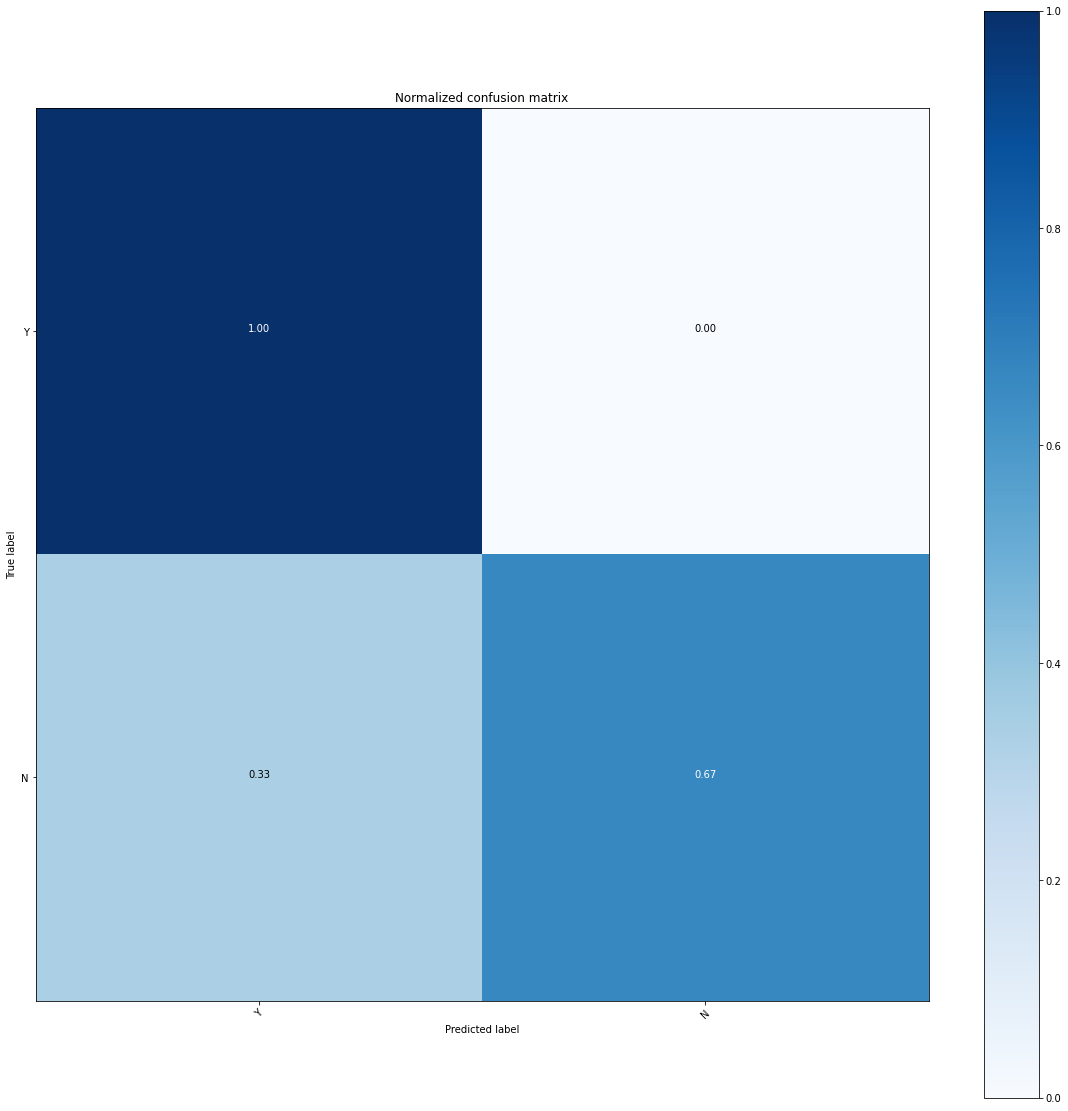

<Figure size 432x288 with 0 Axes>

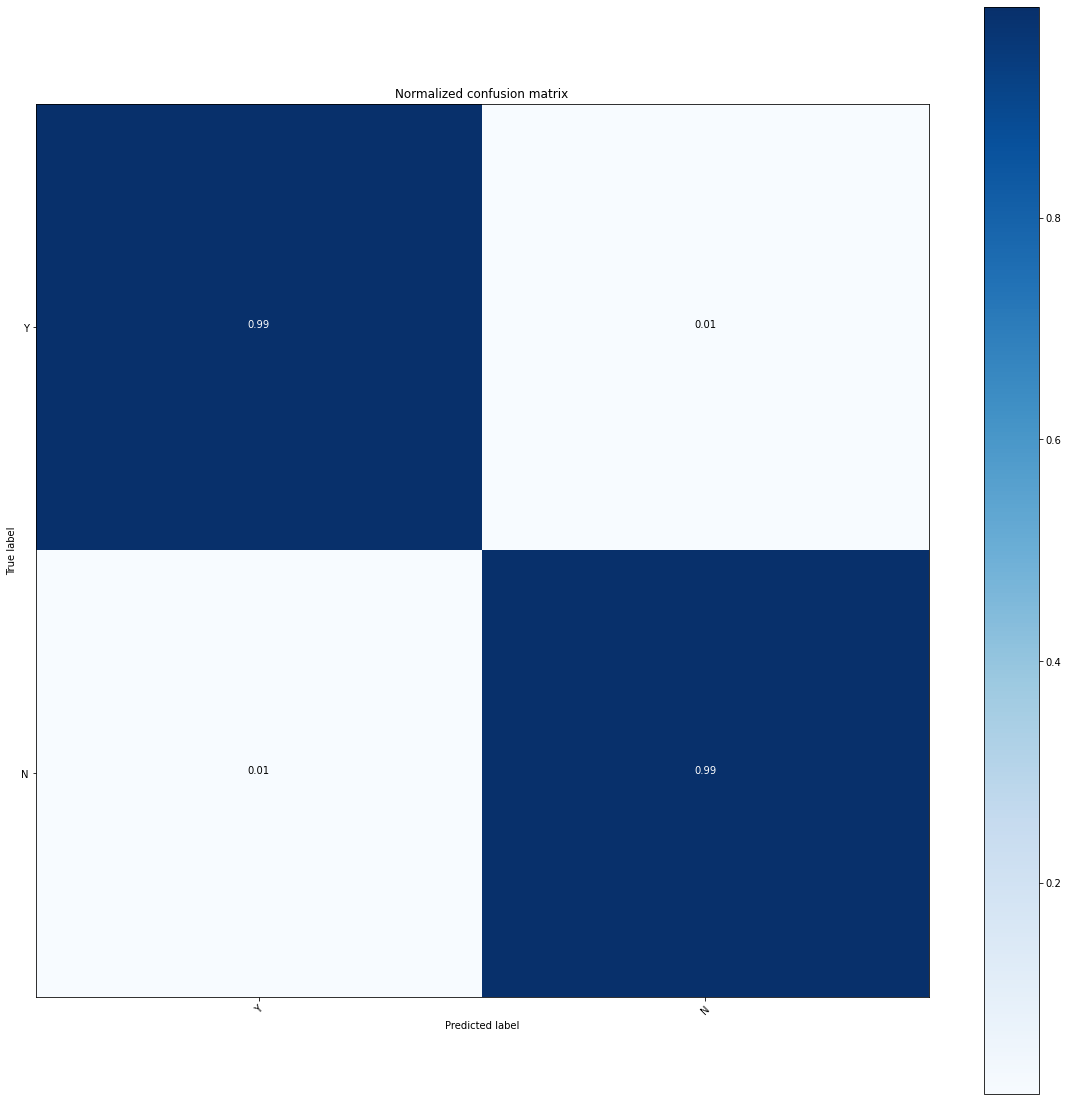

<Figure size 432x288 with 0 Axes>

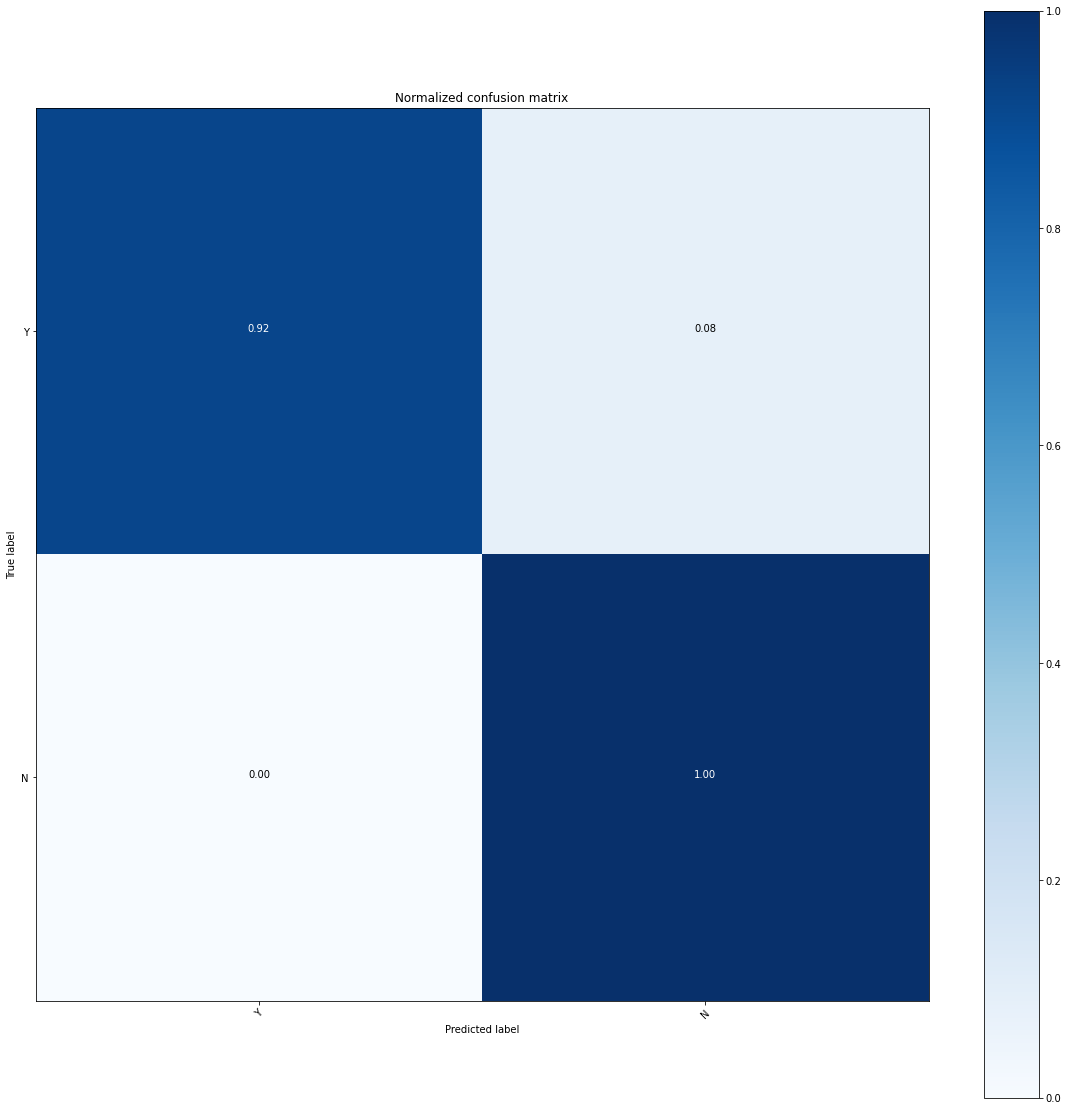

<Figure size 432x288 with 0 Axes>

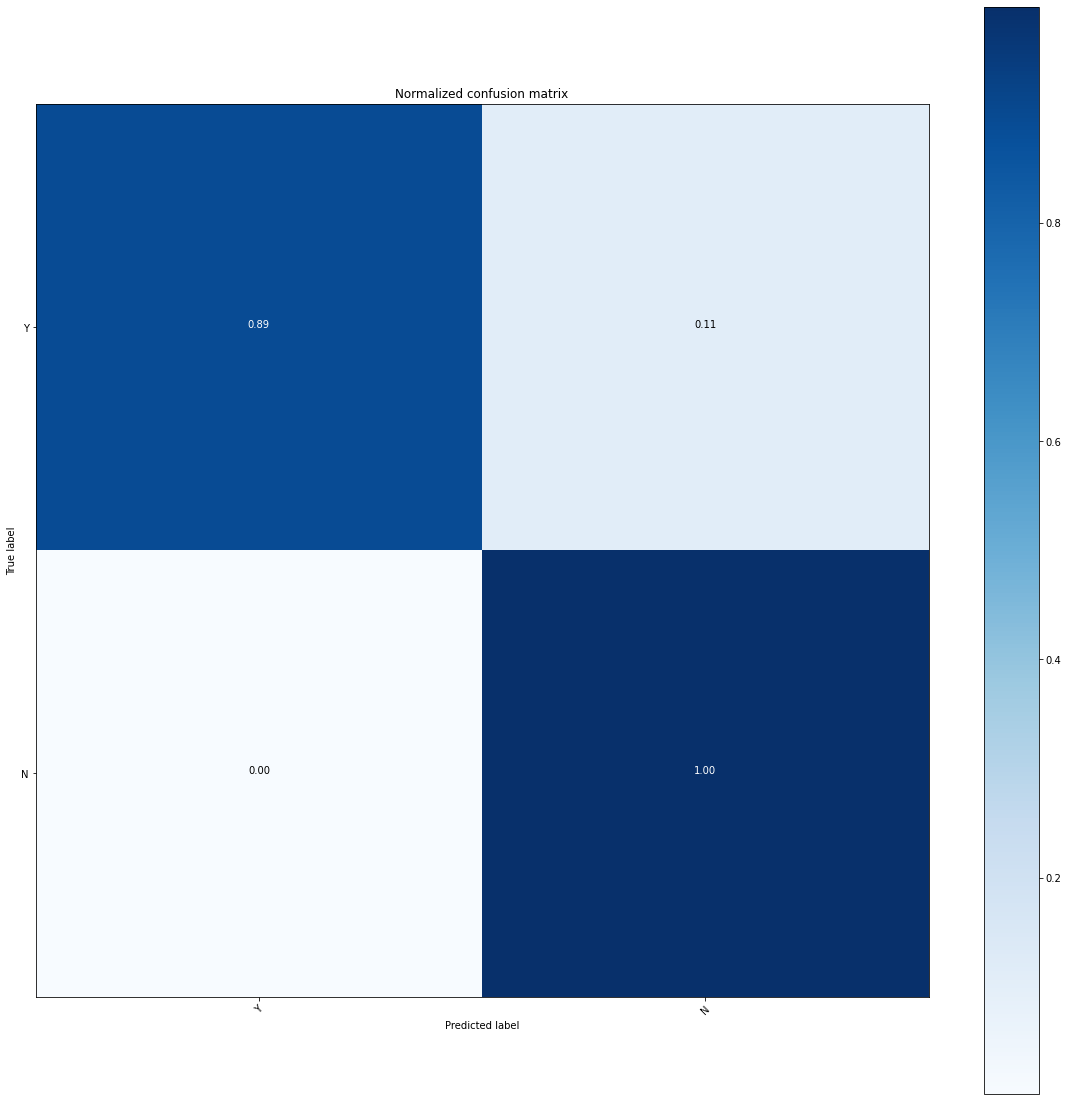

<Figure size 432x288 with 0 Axes>

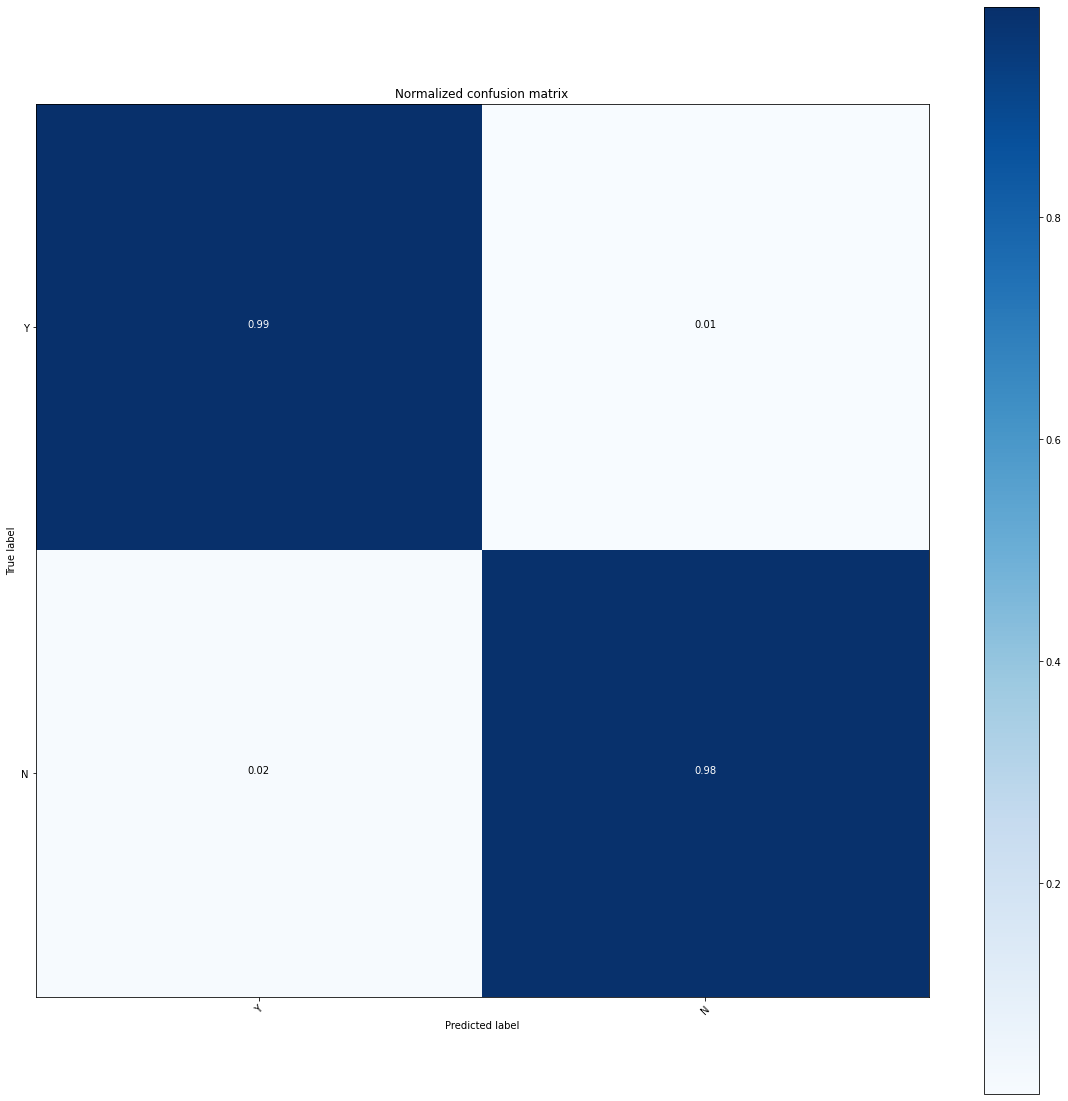

<Figure size 432x288 with 0 Axes>

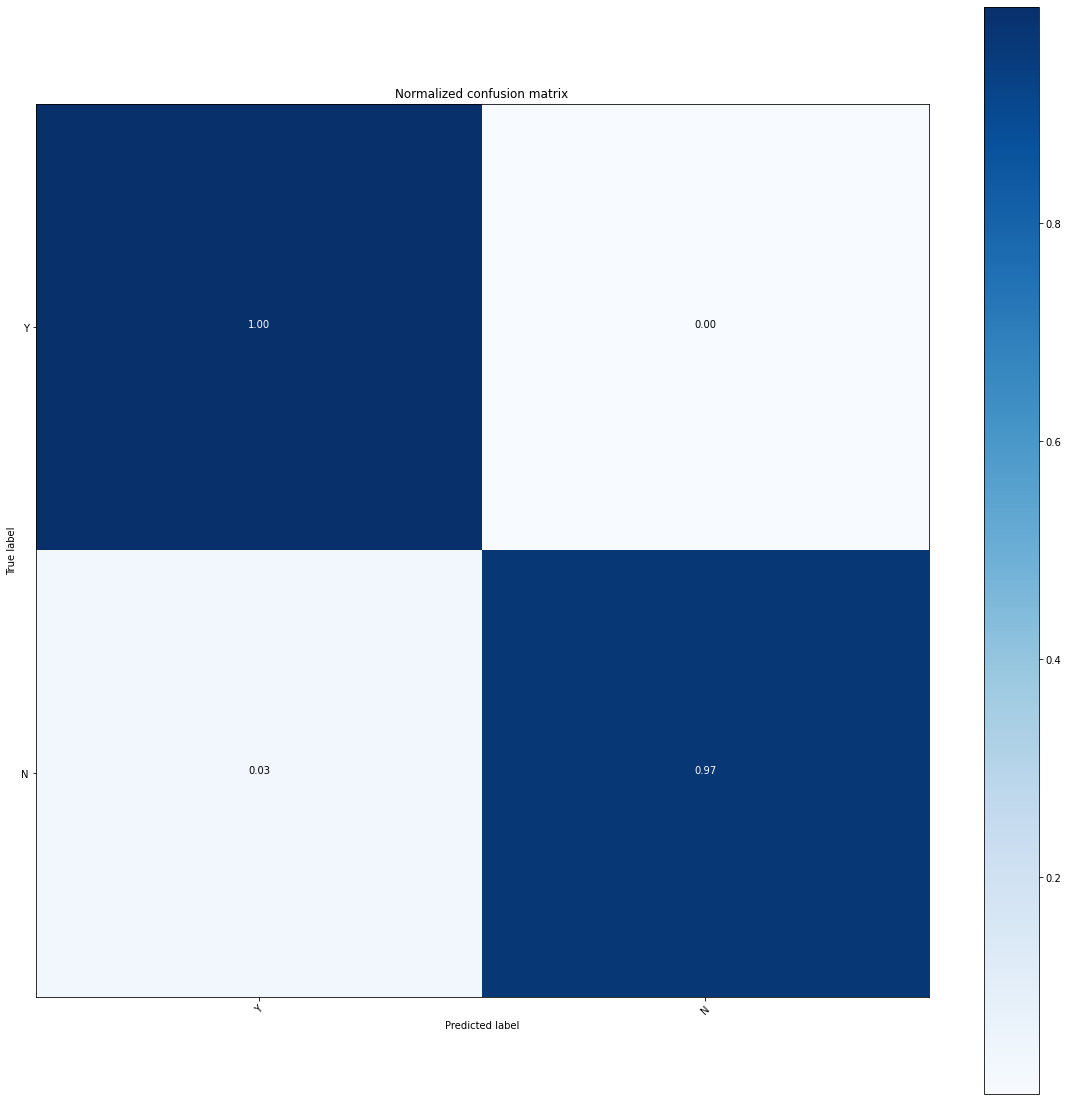

<Figure size 432x288 with 0 Axes>

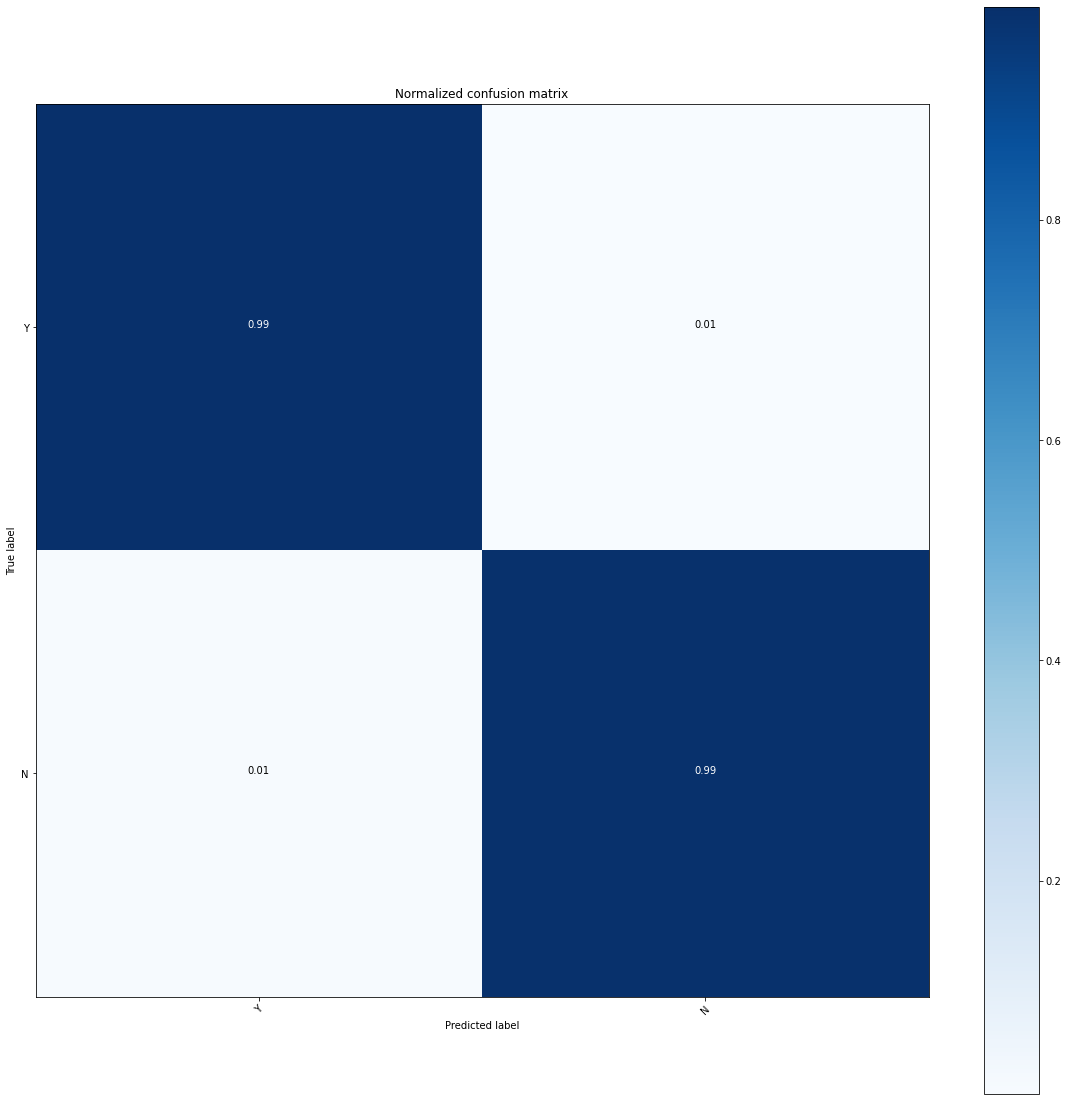

<Figure size 432x288 with 0 Axes>

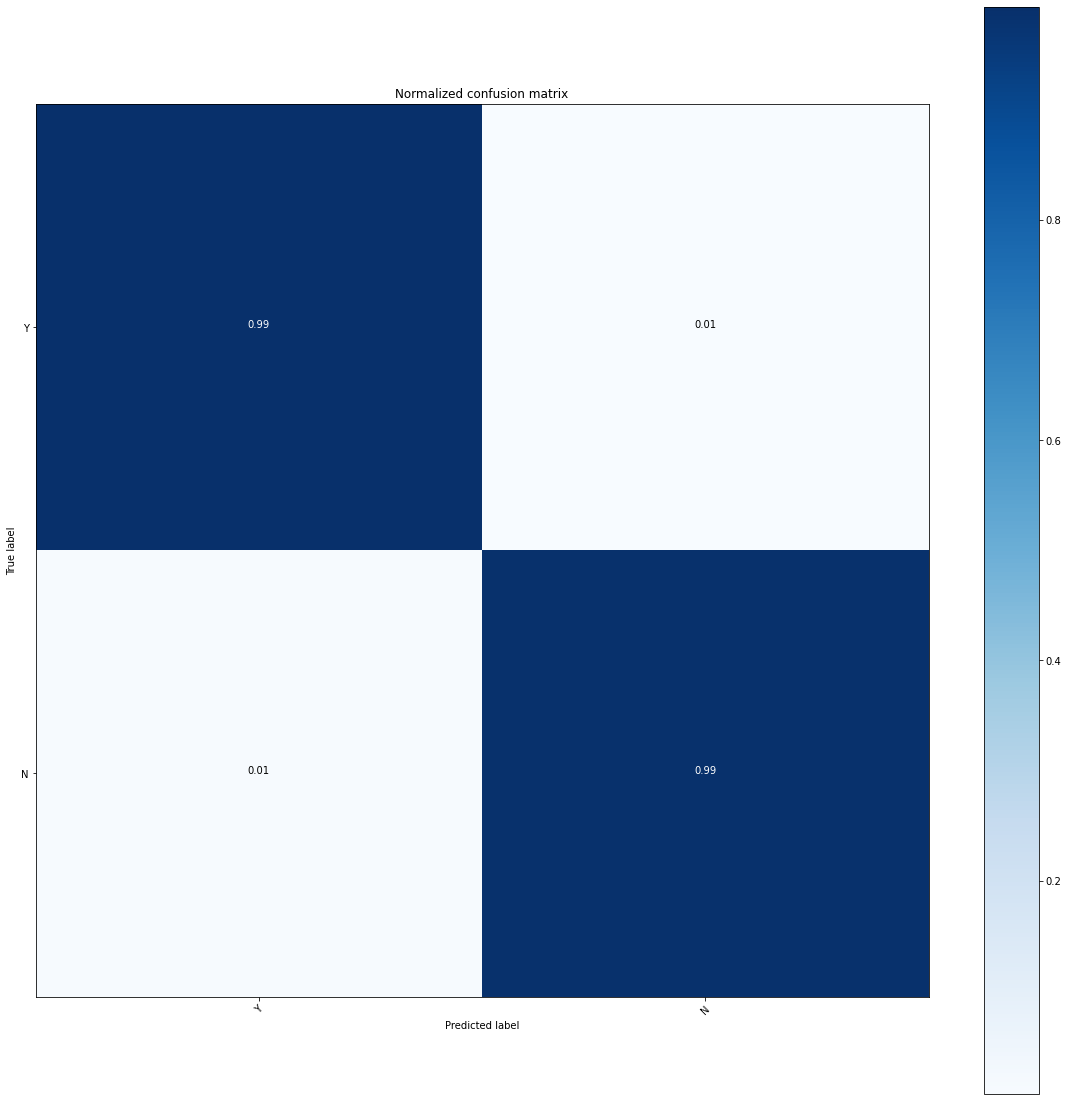

<Figure size 432x288 with 0 Axes>

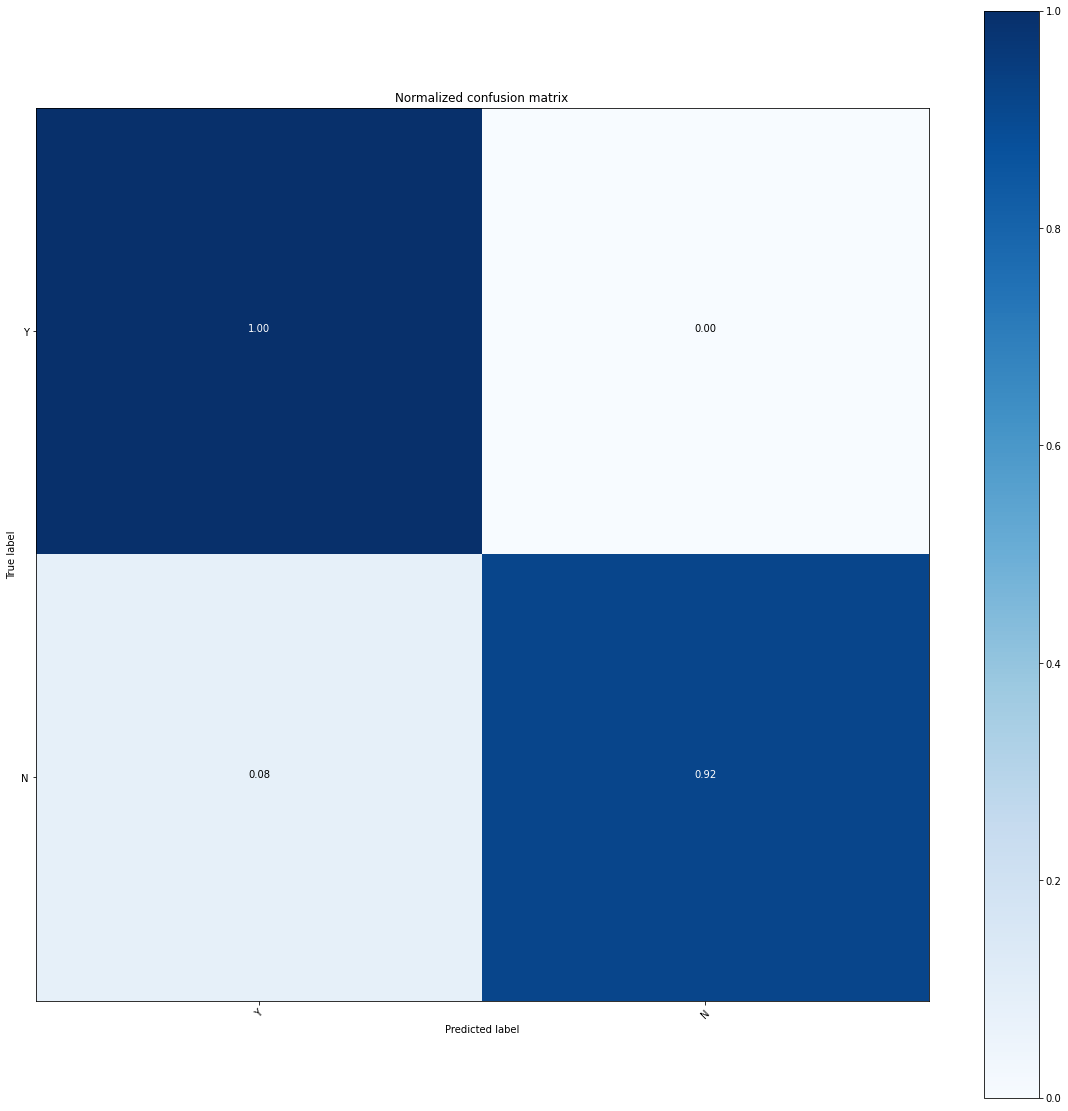

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import multilabel_confusion_matrix
import seaborn as sns

model=keras.models.load_model('PATH-OF-SAVED-MODEL/FOLDER-NAME')

Predictions = model.predict(x_test) #We use keras to predict the mechanisms of the test set, the predicitons are arrays of 9 positions with the probability to belong to each label
evaluate=model.evaluate(x_test,y_test)# We can obtain the metrics for accuracy in the test set in a direct manner by putting the labels
# Important! Transform the probabilities to binary decisions (either you belong to a label or not), we used the typical treshold in literature of 0.5
Predictions_Binary = Predictions.copy()
Predictions_Binary[ np.where( Predictions_Binary >= 0.5 ) ] = 1
Predictions_Binary[ np.where( Predictions_Binary < 0.5 ) ] = 0
#Since both the predictions and the labels are in binary format, we can use SKLearn to plot a report of metrics for our predicitons
print('Metrics Report: ')
report = classification_report(y_test, Predictions_Binary)
print(report)

class_names = ['Y','N']


import itertools
#Function to plot a generated confusion matrix from Alexander Scarlat, you can select the colormap, light or dark theme and the figure size
def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(20,20))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
  
    
# Since we have a multi-label classification, we have to generate a binary matrix for each label
cnf_matrix = multilabel_confusion_matrix(y_test, Predictions_Binary)
np.set_printoptions(precision=2)
#The function does not support a multilabel matrix, so we compute the plot for each matrix inside the multi-label matrix
for i in range(len(cnf_matrix)):
  plt.figure()
  plot_confusion_matrix(cnf_matrix[i], classes=class_names, title='Normalized confusion matrix')
  plt.show()

## **Second Prediction**
Run this if you wish a more straightforward representation of the system behavior. We use the multilabel binarizer to transform the binary predictions to the name of the mechanisms.

In addition, a sorted dictionary is created to later transform said mechanisms back into the original antibiotic name

In [ ]:
model=keras.models.load_model('PATH-OF-SAVED-MODEL/FOLDER-NAME')
Predictions = model.predict(x_test)
Predictions_Binary = Predictions.copy()
Predictions_Binary[ np.where( Predictions_Binary >= 0.5 ) ] = 1
Predictions_Binary[ np.where( Predictions_Binary < 0.5 ) ] = 0

inv=mlb.inverse_transform(Predictions_Binary)

In [ ]:
dd_s=dd.copy()
for key in dd_s:
  dd_s[key].sort()
print(dd_s.values())

dict_values([['acetylation', 'altered target', 'efflux', 'nucleotidylation', 'phosphorylation'], ['altered target', 'efflux', 'hydrolysis'], ['reprogramming peptidoglycan biosynthesis'], ['ADP-ribosylation', 'altered target', 'efflux'], ['acetylation', 'altered target', 'efflux', 'hydrolysis', 'nucleotidylation', 'phosphorylation'], ['altered target', 'efflux', 'monooxygenation'], ['altered target', 'efflux'], ['altered target'], ['acetylation', 'altered target', 'efflux']])


## **Output CSV Generation**
The cell generates a CSV of the labels with the original format, antibiotic name

In [ ]:
out=open('DESIRED-OUT-PATH/out.csv','w')
out.write('preds,gene''\n') #Writing the header
for i in inv:
  try:
    out.write(str(list(dd_s.keys())[list(dd_s.values()).index(list(i))]) +'\n')# We use this line of code to transform each array of mechanisms (values) to antibiotic names (keys)
  except ValueError:
    out.write('betalactams''\n') #In case the combination of mechanisms is not found, we put betalactams as the class. This is to avoid errors in further steps and the frecuency of this event is negligible.
out.close()

## **Calculation of metrics for antibiotic name**
This is a copy of the results tab seen before but now everything is fused into a single confusion matrix, making the visualization of the performance much easier.

Metrics Report: 
                 precision    recall  f1-score   support

Aminoglycosides       0.90      0.98      0.94       132
  Glycopeptides       1.00      0.92      0.96        48
   Lipopeptides       0.85      0.73      0.79        15
            MLS       1.00      0.81      0.90        48
       Phenicol       0.94      0.97      0.95        31
       Rifampin       1.00      0.67      0.80        15
   Sulfonamides       0.69      1.00      0.81        11
  Tetracyclines       0.97      0.97      0.97        35
    betalactams       0.99      1.00      1.00       623

       accuracy                           0.97       958
      macro avg       0.93      0.89      0.90       958
   weighted avg       0.97      0.97      0.97       958



<Figure size 432x288 with 0 Axes>

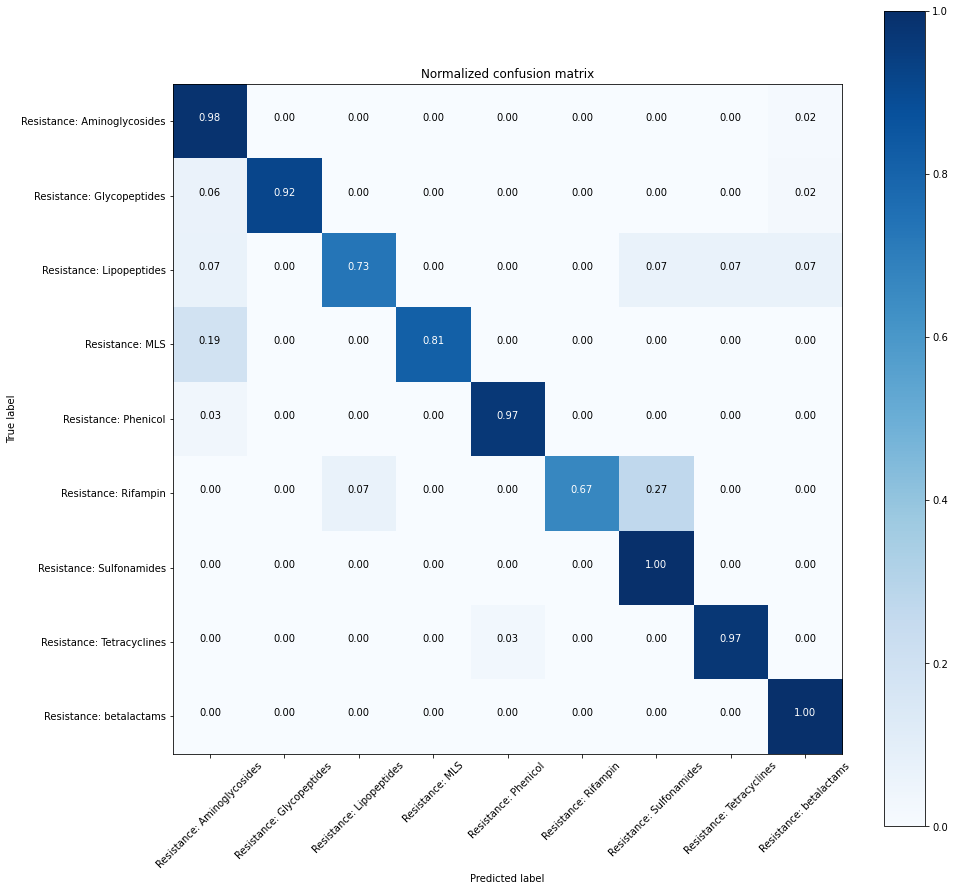

In [ ]:
prediction=pd.read_csv('DESIRED-OUT-PATH/out.csv')
results=prediction['preds']
# We have to inverse transform the real labels as well
label=mlb.inverse_transform(y_test)
decode_label=[]
# Returning labels to antibiotic name with the same criteria as the predictions
for i in label:
  try:
    decode_label.append(str(list(dd_s.keys())[list(dd_s.values()).index(list(i))]))
  except ValueError:
    decode_label.append('betalactams')

#This function allows you to see the values for each class separately, call it with the confusion matrix and the row of the metric you wish to analyze separately
def separate_metrics(matrix,row):
  TP=matrix[row][row]
  FN=sum(matrix[row,:])-TP
  FP=sum(matrix[:,row])-TP
  TN=sum(sum(matrix))-TP-FP-FN
  return TP,FP,TN,FN
  
#Classification report
print('Metrics Report: ')
report = classification_report(decode_label, results)
print(report)


class_names = ['Resistance: Aminoglycosides','Resistance: Glycopeptides','Resistance: Lipopeptides','Resistance: MLS','Resistance: Phenicol','Resistance: Rifampin','Resistance: Sulfonamides','Resistance: Tetracyclines','Resistance: betalactams']

from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(15,15))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
  
    

cnf_matrix = confusion_matrix(decode_label, results)
np.set_printoptions(precision=2)

# Plot of the single confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, title='Normalized confusion matrix')
plt.show()